In [1]:
from sliderule import sliderule, icesat2

In [4]:
POLY = [ 
    {"lat": 64.77637826423998, "lon": -50.9792153524102  },
    {"lat": 64.72637491870586, "lon": -50.9792153524102  },
    {"lat": 64.72637491870586, "lon": -50.78460039705306 },
    {"lat": 64.77637826423998, "lon": -50.78460039705306 },
    {"lat": 64.77637826423998, "lon": -50.9792153524102  } 
]

## Original Method - using `atl06p` and `atl03sp`
When you get the ATL03 photons that correspond to the ATL06-SR elevations, there are a couple of things you should do:
* Reduce the number of tracks being requested.  It is very easy to make an atl03sp request that returns 100M photons and crashes your client.  In the example below, I use the "rgt" and "cycle" parameter to only request photons for one of the granules that made up the `atl06p` response.  You can limit the data in other ways such as providing a list of only a few resources in the `atl06p` resource argument, setting a time range ("t0", and "t1"), providing a track number (1, 2, or 3), or a beam ("gt1l", "gt1r", "gt2l", etc).
* The "len" and the "res" parameters should match.  Otherwise it is possible to either get duplicate data (when "res" < "len") or gaps in the data ("when "len" < "res").
* Set "pass_invalid" to True so that the server doesn't attempt to filter the data.  Otherwise, other parameters will come into play like the along track spread of the photons given the segment length you requested.  These types of checks make sense when the photons are being passed along to another processing step, but don't make sense when you just want all the data.

In [5]:
gdf06 = icesat2.atl06p({"poly": POLY}) # provided just for comparison

In [7]:
gdf03 = icesat2.atl03sp({"poly": POLY, "rgt": 1169, "cycle": 24, "len": 20, "res": 20, "pass_invalid": True})

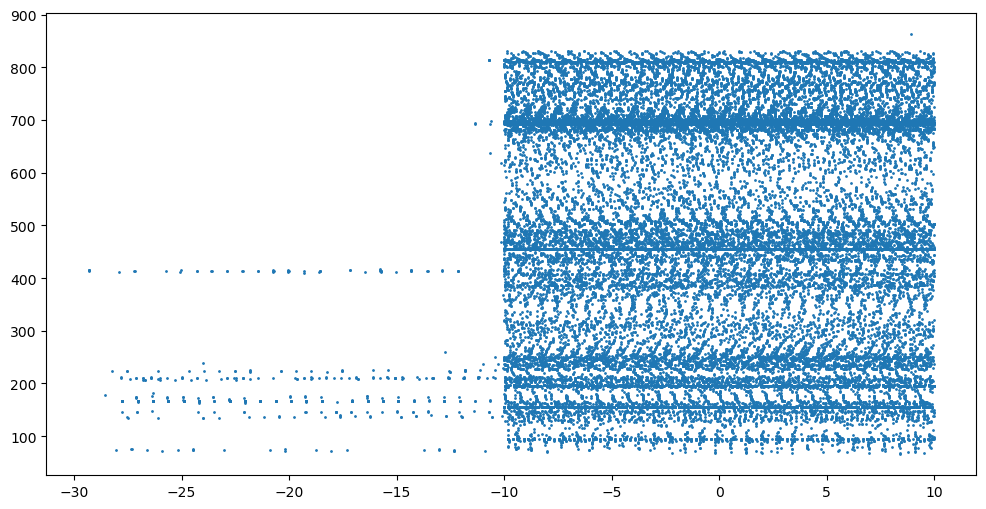

In [9]:
## plot height parameter for photon
import matplotlib.pyplot as plt
# Plot the DEM with the updated zoom-in
fig, ax = plt.subplots(figsize=(12, 6))

# Plot `gdf6['h_mean']` as colored scatter points
ax.scatter(gdf03['x_atc'], gdf03['height'],s=1)

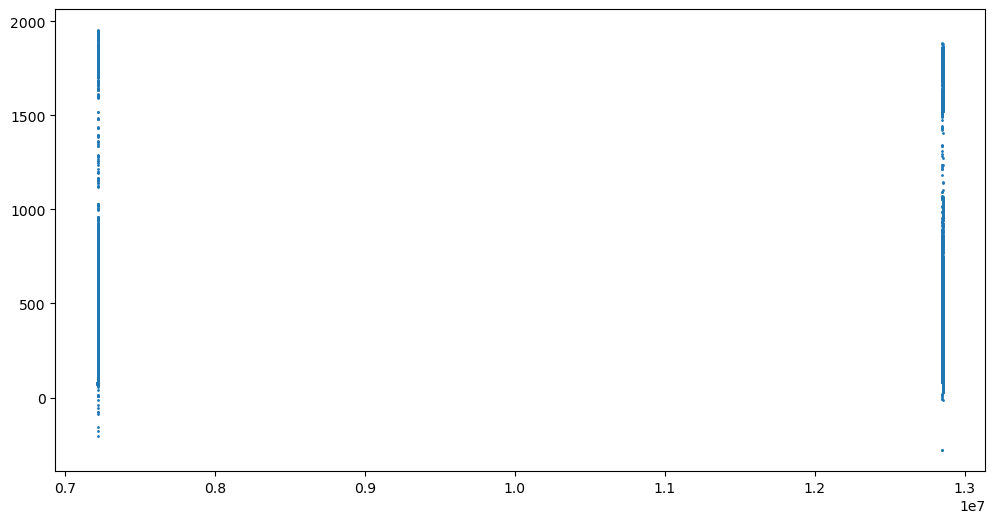

In [10]:
## plot height parameter for photon
import matplotlib.pyplot as plt
# Plot the DEM with the updated zoom-in
fig, ax = plt.subplots(figsize=(12, 6))

# Plot `gdf6['h_mean']` as colored scatter points
ax.scatter(gdf06['x_atc'], gdf06['h_mean'],s=1)

## New Method - using `atl03x`
The original `atl06p` and `atl03sp` endpoints were implemented using stream processing on the backend servers.  This limited memory usage and was ideal for distributing processing requests, but we ran into some limitations when implementing some of the more recent SlideRule features - specifically our raster sampling functionality.  For that reason, we've transitioned to a dataframe processing model on the backend servers.  This model is being rolled out via the x-series of endpoints.

There are a couple of differences and benefits to using the `atl03x` x-series endpoint over the `atl06p` and `atl03sp` endpoints:
* The `atl03x` endpoint handles both reading the ATL03 photons as well as any downstream processing.  So to produce ATL06-SR elevations from the ATL03 photon cloud, the `atl03x` endpoint is called and passed the `fit` parameter.
* The `atl03x` endpoint does not need ATL06-SR related parameters (like `atl03sp` did) in order to work; that is because the code is properly separated on the server-side.  So 'len', 'res', and 'pass_invalid' don't need to be provided.
* The `atl03x` endpoint is generally faster and can handle much larger requests.  With `atl03sp`, dataframes approaching 1M rows could dramatically slow down the client; but with `atl03x` we use parquet behind the scenes which allows dataframes that are many millions of rows without noticeable degredation.
* All future features will be implemented in the x-series endpoints.  So things like the ATL24 classifications, and distributed raster sampling, will all only work with these new endpoints.

In [1]:
gdf06x = sliderule.run("atl03x", {"poly": POLY, "fit": {}}) # provided just for comparison

In [12]:
gdf03x = sliderule.run("atl03x", {"poly": POLY, "rgt": 1169, "cycle": 24})

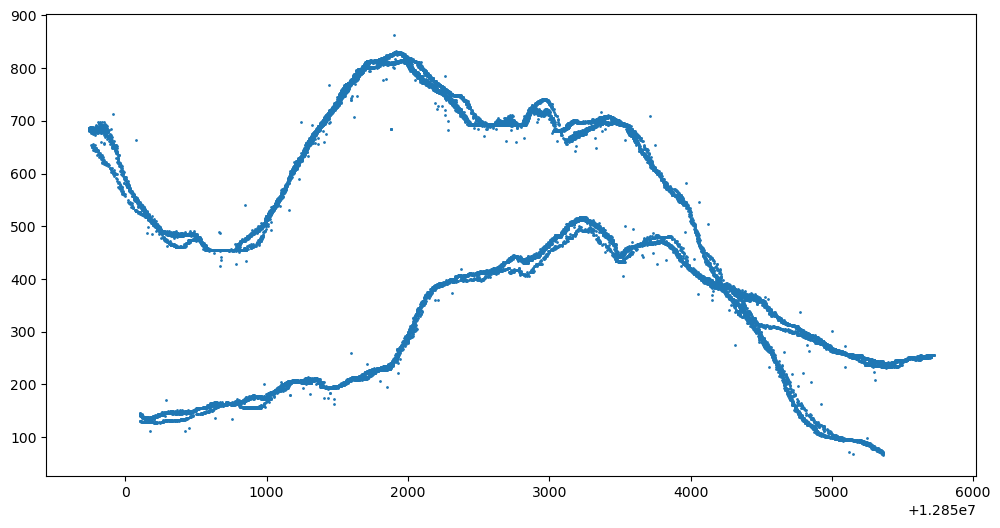

In [13]:
## plot height parameter for photon
import matplotlib.pyplot as plt
# Plot the DEM with the updated zoom-in
fig, ax = plt.subplots(figsize=(12, 6))

# Plot `gdf6['h_mean']` as colored scatter points
ax.scatter(gdf03x['x_atc'], gdf03x['height'],s=1)


## Fun Method - using our new web client at https://client.slideruleearth.io

When you go to the web client you can plot the photon cloud for a given ATL06-SR result by following these steps:
1. Make a request using the map on the "Request" page - draw your area of interest and hit "Run SlideRule"
2. Once complete it will immediately transition you to the "Analysis" page
3. Select the track you are interested in looking at - it will display on the scatter plot to the right
4. Click the "Show Photon Cloud" button below the scatter plot to see the photon cloud overlay the ATL06-SR elevations

The web client is brand new and still under a lot of development.  As such, there are still some things we need to get working:
* The "Advanced" tab that allows you to modify the parameters of the request is not functional, but will be very soon!
* We only allow you to export the data as parquet or CSV; we are not sure yet if we will support other options
* We currently only support the Mercator projection - others will be available in the months to come
  

![Web Client](https://slideruleearth.io/web/assets/images/sliderule_web_client.png)

Greenland

[Planet SkySat Image: 20191024_151720_ssc1_u0003_pansharpened_dn.tif], [ICESat-2 ATLAS granule: ATL03_20190511210825_06660305_002_02.h5] [RGT 666 gt3l (strong beam), collected 2019-May-11 ​at 21:08 GMT ​= ​19:08 local time, day-time data].

ICESat-2 data from RGT 666 collected on 2019-May-11 (track gt3l)


region = [
    {"lon": 576400, "lat": 7672600},
    {"lon": 575900, "lat": 7672600},
    {"lon": 575900, "lat": 7671700},
    {"lon": 576400, "lat": 7671700},
    {"lon": 576400, "lat": 7672600}
]